# Notebook 3 - Identifiability

In this notebook we compare two different branching pathways with 4 genes, from both ‘single-cell’ and ‘bulk’ viewpoints.

## Networks

In [8]:
from harissa import NetworkModel, NetworkParameter
from harissa.simulation import BurstyPDMP

n_genes = 4
models = [
    NetworkModel(
        NetworkParameter(n_genes), 
        simulation=BurstyPDMP(use_numba=True)
    ) for _ in range(2)
]

degradation_rna = 1.0
degradation_protein = 0.2

for i, model in enumerate(models):
    param = model.parameter

    param.degradation_rna[:] = degradation_rna
    param.degradation_protein[:] = degradation_protein
    param.burst_frequency_min[:] = 0.0 * param.degradation_rna
    param.burst_frequency_max[:] = 2.0 * param.degradation_rna
    param.creation_rna[:] = param.degradation_rna * param.rna_scale() 
    param.creation_protein[:]=param.degradation_protein * param.protein_scale()
    param.basal[1:] = -5.0
    param.interaction[0, 1] = 10.0
    param.interaction[1, 2] = 10.0
    param.interaction[1, 3] = 10.0
    param.interaction[2 + i, 4] = 10.0

This time we set the node positions manually to better compare the two networks.

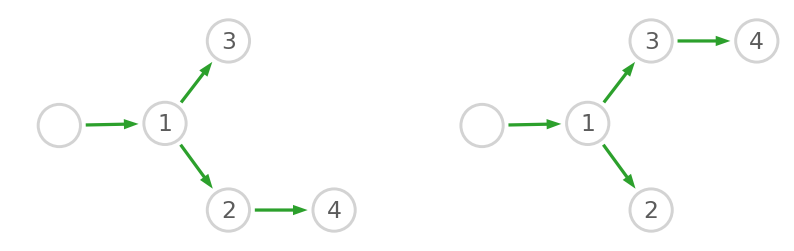

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from harissa.plot import plot_network

fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)

# Number of genes including stimulus
G = models[0].parameter.basal.size

# Node labels and positions
names = [''] + [f'{i+1}' for i in range(4)]
pos = [
    np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7,-0.4]]),
    np.array([[-0.6,0],[-0.1,0.01],[0.2,-0.4],[0.2,0.4],[0.7, 0.4]]),
]

# Draw the networks
for i, model in enumerate(models):
    ax = plt.subplot(gs[0, i])
    plot_network(
        model.parameter.interaction, 
        pos[i], 
        axes=fig.gca(), names=names, scale=6
    )

## Datasets

Here we use Numba for simulations: this option takes some time to compile (~8s) but is much more efficient afterwards, so it is well suited for large numbers of genes and/or cells.

In [10]:
# Number of cells
C = 10000
# Set the time points
time_points = np.linspace(0.0, 9.0, 10)
nb_cells_per_time_point = C // time_points.size

print('Time points: ' + ', '.join([f'{ti}' for ti in time_points]))
print(f'{nb_cells_per_time_point} cells per time point (total {C} cells)')

# Generate data
data_list = [
    model.simulate_dataset(
        time_points=time_points, 
        n_cells=nb_cells_per_time_point,
        burn_in_duration=5.0
    ) for model in models
]

Time points: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0
1000 cells per time point (total 10000 cells)


## Population-average trajectories

Looking at network structures, it is clear that population-average trajectories, i.e., bulk data, does not contain enough information to recover all interactions: if $d_{0,2}=d_{0,3}$ and $d_{1,2}=d_{1,3}$, one *cannot distinguish* between edges 2 → 4 and 3 → 4 as genes 2 and 3 have the same average dynamics.

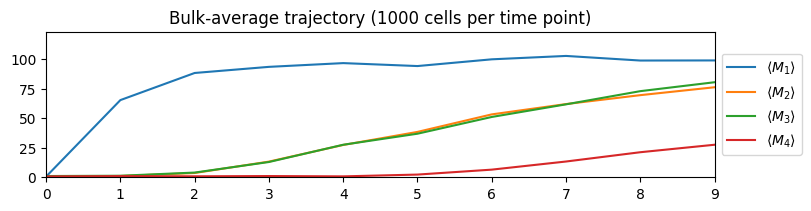

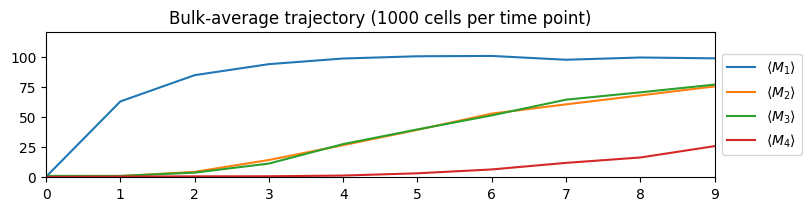

In [11]:
from harissa.plot.plot_datasets import plot_average_traj

for data in data_list:
    plot_average_traj(data)

## Inference from single-cell data

Here, since we know the number of edges we are looking for, we choose to keep only the strongest 4 edges instead of applying a cutoff to the weights.

In [12]:
inter = {}
for k, data in enumerate(data_list, start=1):
    # Calibrate the model
    model = NetworkModel(NetworkParameter(n_genes))
    model.degradation_rna[:] = degradation_rna
    model.degradation_protein[:] = degradation_protein
    model.fit(data)
    # Keep the strongest four edges
    inter[k] = np.zeros((G,G))
    a = np.abs(model.parameter.interaction)
    a -= np.diag(np.diag(a))
    for n in range(4):
        (i,j) = np.unravel_index(np.argmax(a, axis=None), a.shape)
        inter[k][i,j] = model.parameter.interaction[i,j]
        a[i,j] = 0
    print(f'inter[{k}] = \n{inter[k]}')

inter[1] = 
[[0.         3.34306936 0.         0.         0.        ]
 [0.         0.         1.68874716 1.71681694 0.        ]
 [0.         0.         0.         0.         0.56606724]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]
inter[2] = 
[[0.         3.33635072 0.         0.         0.        ]
 [0.         0.         1.78150063 1.69442886 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.57464374]
 [0.         0.         0.         0.         0.        ]]


## Drawing inferred networks

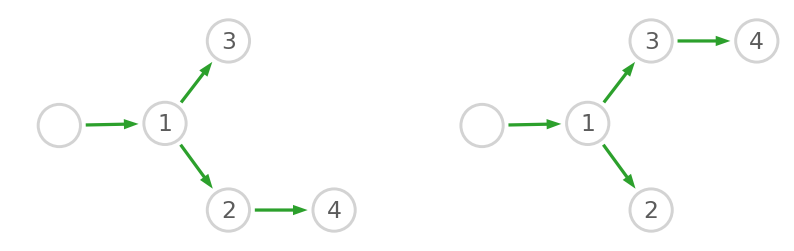

In [13]:
fig = plt.figure(figsize=(10,3))
gs = gridspec.GridSpec(1,2)

# Draw the networks
for i in range(2):
    ax = plt.subplot(gs[0, i])
    plot_network(inter[i+1], pos[i], axes=fig.gca(), names=names, scale=6)

The result might not be always perfect, but the edges 2 → 4 and 3 → 4 should generally be inferred correctly.